In [1]:
from nilearn import image, plotting
from nilearn.image import new_img_like
import numpy as np
import os, glob, scipy
import matplotlib.pyplot as plt
folder = 'D:\\subj_sara\\data\\'
subjs = ['01','04']
th_mask = image.load_img('D:\\subj_sara\\Thalamus_bilateral_AAL.nii')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\davide\miniconda3\envs\neuroimg\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [206]:
results = []
for ns, s in enumerate (subjs):
    this_res = [] # results of participant s
    print('Subject: ' + s)

    # Iterating sessions of participant s
    func_path = glob.glob(folder + 'swasub-' + s + '*.nii')
    onsets_path = glob.glob(folder + 'onset_switches_sub-' + s + '*.mat')

    all_sessions_res = [] # list with results of all sessions
    for nses, session in enumerate(func_path):

        # Loading scan / onsets for participant s and session "session"
        print('Iterating session ' + str(nses))
        func = image.load_img(session)

        # Or you can define it above
        TR = func.header['pixdim'][4] # = 1.5?

        # questo è il casino per accedere agli onsets
        onsets_data = list(scipy.io.loadmat(onsets_path[nses]).items())[-1][1][0]
        onsets_vol = onsets_data / TR

        print('N onsets: ' + str(len(onsets_vol)))
        # Resampling TH mask
        if not 'th_res' in locals():
                th_res = image.resample_to_img(th_mask, func, interpolation = 'nearest')

        # Applying mask
        func = func.get_fdata()
        for vol in range(0, func.shape[3]):
            func[:,:,:,vol] = np.multiply(func[:,:,:,vol], th_res.get_fdata())

        all_onsets_results = []
        for nons, this_onset in enumerate(onsets_vol):
            data = func[:,:,:, int(this_onset)-5:int(this_onset)+5]
            data = np.where(data == 0, np.nan, data)

            these_volumes_means = []
            # media dell'attivazione del talamo in ognuno dei 10 volumi
            for data_vol in range(0, data.shape[3]):
                these_volumes_means.append(np.nanmean(data[:,:,:, data_vol]))
            
            #shape = n onsets * n volumes
            all_onsets_results.append(these_volumes_means)

        # average of the N volumes around each onset 
        this_res.append([sum(sub_list) / len(sub_list) for sub_list in zip(*all_onsets_results)])

    # average of the sessions of participant s
    all_sessions_res = [sum(sub_list) / len(sub_list) for sub_list in zip(*this_res)]

    # Here's where we append the results of the average of the N sessions of each participant
    results.append(all_sessions_res)


Subject: 01
Iterating session 0
N onsets: 30
Iterating session 1
N onsets: 34
Subject: 04
Iterating session 0
N onsets: 26
Iterating session 1
N onsets: 34


In [212]:
this_res

[[329.02670716331545,
  328.71418108209303,
  328.67429375426815,
  329.1054385584291,
  328.9476975653921,
  329.0646818468244,
  328.88371091918657,
  328.82511445241687,
  328.9477671160945,
  328.94738458723134],
 [324.89501086644253,
  324.7855012399091,
  324.8924579465428,
  324.650249671053,
  324.56735955305766,
  324.7990370339608,
  324.754015227812,
  324.89525020268314,
  324.98760739864014,
  325.05815840378665]]

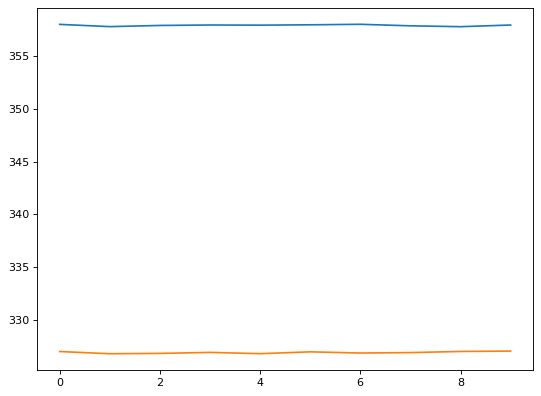

In [211]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for sbj_results in results:
    plt.plot(np.asarray(sbj_results))

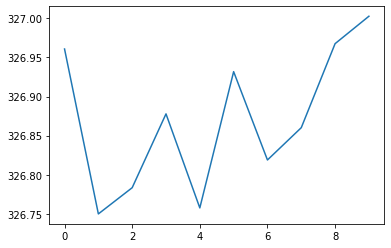

In [213]:
plt.plot(np.asarray(sbj_results))